# Data-Oriented Programming Paradigms: Exercise 3

This jupyter notebook should be used for merging the different datasets we have.   
Every person has their own cell where they can prepare their data so it matches the structure we agreed on.  
[Format Picture](pandasformat.png) - The two indexes should be named **year** and **country_name**

##### Take Note: (Add additional points to the list if needed)

* Put your data files into the data/ directory (make sure your files have reasonable size)
* Try to name your data variable appropriately (e.g. use initials)
* When you commit your changes try to reduce unnecessary jupyter notebook output to a minimum so it is easier for everyone to read the commits on Github

## General Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry
import missingno as msno
from fancyimpute import IterativeImputer
from biokit.viz import corrplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

Using TensorFlow backend.


## Data Loading and preparation (done individually)

The data is collected from different sources. Each group member collected relevant data. The outcome of the collection is 4 csv files. The data mainly includes information about the health, the bank information and the status of the country. <br>
The data is loaded from each file. Attributes are selected according to relevance. The attributes "year" and "country_name" are present in all datasets. The names of these attributes are changed and set as index all datasets to facilitate data merging. <br>
Since the data merge will be performed on the country names and years, the country names should be unified through all the datasets. This is done through checking the problematic country names and fixing them case by case. <br>
It is for example common to have names of countries which are problematic because they have special characters. There are also some abbriviations and typos which should also be considered. <br>
To investigate all of these concerns, a list of the countries is imported from the package pycoutries. The name of the countries which are contained in the merged dataset and not contained in the correct list of countries are investigated. The list obtained from the pycountry package includes 249 countries, territories, or areas of geographical interest according to the official codes in ISO 3166-1.<br>
In the following, one can see that there are many changes that should be performed. For example, "Arab World", "Europe & Central Asia" and "East Asia & Pacific" should be deleted since they are rather regions and not countries. <br>
"Iran, Islamic Rep." and "Iran (Islamic Republic of)" are the same country. However, they are named differently. They are both changed to "Iran, Islamic Republic of". There are many other countries which have this same problem. <br>
"Cote d'Ivoire" which is in french is missing a special character and is changed to "Côte d'Ivoire". Many other changes are also performed. <br>
The former Yugoslav republic of Macedonia and Republic of North Macedonia are also in the dataset and should be handled. In this case, the life expectancy is NA for it, so it will be simply deleted.
Kosovo is not listed as an ISO standard country. The unofficial 2 and 3-digit codes are used by the European Commission and others until Kosovo is assigned an ISO code. Therefore, it is not in the list of countries. But, it is still appended to the list of countries since most members of the European Union (EU) recognized Kosovo's declaration of independence.

In [2]:
# get the list of all countries in the world
countries_list = [x.name for x in pycountry.countries]
countries_list.append('Kosovo')

def check_problematic_names(data_to_check):
    try:
        # this will check the country names after the changes and after setting an index
        return np.setdiff1d(data_to_check.index.get_level_values(1), countries_list)
    except:
        # this will check the country names before the changes and before setting an index
        return np.setdiff1d(data_to_check.country_name, countries_list)
        
def unify_names(data_to_correct, key, value):
    data_to_correct.country_name = np.where(data_to_correct.country_name==key, 
                                           value, data_to_correct.country_name)
def correct_countries_names(data_to_correct):
    # delete irrelevant rows with irrelevant indices
    countries_to_delete = ['Arab World', 'East Asia & Pacific', 'East Asia & Pacific (IDA & IBRD countries)',
                          'East Asia & Pacific (excluding high income)', 'Central Europe and the Baltics',
                          'Euro area', 'Europe & Central Asia','Europe & Central Asia (IDA & IBRD countries)',
                           'Europe & Central Asia (excluding high income)', 'European Union',
                           'Fragile and conflict affected situations', 'Heavily indebted poor countries (HIPC)', 
                           'High income', 'Latin America & Caribbean',
                           'Latin America & Caribbean (excluding high income)',
                           'Latin America & the Caribbean (IDA & IBRD countries)',
                           'Least developed countries: UN classification',
                           'Low & middle income', 'Low income', 'Lower middle income', 
                           'Middle East & North Africa', 'Middle East & North Africa (IDA & IBRD countries)',
                           'Middle East & North Africa (excluding high income)',
                           'Middle income', 'Sub-Saharan Africa (IDA & IBRD countries)',
                           'Sub-Saharan Africa (excluding high income)', 'Upper middle income',
                          'OECD members', 'Other small states', 'Early-demographic dividend', 
                           'North America','Sub-Saharan Africa', 'Small states',
                           'South Asia', 'South Asia (IDA & IBRD)', 'Post-demographic dividend',
                           'Pre-demographic dividend','Not classified', 'Pacific island small states',
                          'World', 'Late-demographic dividend', 'Caribbean small states',
                            'United Kingdom of Great Britain and Northern Ireland', 'Channel Islands' ]
    for country_to_delete in countries_to_delete:
        try:
            data_to_correct = data_to_correct.drop(data_to_correct[data_to_correct.country_name == \
                                                                   country_to_delete].index)
        except:
            pass
    # correct country names.
    countries_to_correct = {"Bahamas, The":"Bahamas",
                           "Bolivia":"Bolivia, Plurinational State of",
                           "Bolivia (Plurinational State of)":"Bolivia, Plurinational State of",
                           "Iran, Islamic Rep.":"Iran, Islamic Republic of",
                            "Iran (Islamic Republic of)":"Iran, Islamic Republic of",
                           'Swaziland':'Eswatini',
                           'Yemen, Rep.':'Yemen',
                            'Moldova':'Moldova, Republic of',
                            'Republic of Moldova':'Moldova, Republic of',
                            'Vietnam':'Viet Nam',
                            'Micronesia, Fed. Sts.':'Micronesia, Federated States of',
                            'Micronesia (Federated States of)':'Micronesia, Federated States of',
                            'Venezuela, RB':'Venezuela, Bolivarian Republic of',
                            'Venezuela (Bolivarian Republic of)':'Venezuela, Bolivarian Republic of',
                            'Congo, Dem. Rep.':'Congo, The Democratic Republic of the',
                            'Congo, Rep.':'Congo',
                             'Democratic Republic of the Congo':'Congo, The Democratic Republic of the',
                             "Cote d'Ivoire":"Côte d'Ivoire",
                             'Czech Republic':'Czechia',
                             'Gambia, The':'Gambia',
                             'Egypt, Arab Rep.':'Egypt',
                             'British Virgin Islands':'Virgin Islands, British',
                             'Virgin Islands (U.S.)':'Virgin Islands, U.S.',
                              'Curacao':'Curaçao', 'Kyrgyz Republic':'Kyrgyzstan',
                             'Lao PDR':"Lao People's Democratic Republic",
                             'Tanzania':'Tanzania, United Republic of',
                             'United Republic of Tanzania':'Tanzania, United Republic of',
                             'Slovak Republic':'Slovakia',
                             'United States of America':'United States',
                             'West Bank and Gaza':'Palestine, State of',
                             'Macao SAR, China':'Macao',
                             'Hong Kong SAR, China':'Hong Kong',
                             "Democratic People's Republic of Korea":"Korea, Democratic People's Republic of",
                            'Korea, Dem. People’s Rep.':"Korea, Democratic People's Republic of",
                            'Korea, Rep.':'Korea, Republic of',
                            'Republic of Korea':'Korea, Republic of', 
                             'St. Kitts and Nevis':'Saint Kitts and Nevis',
                            'St. Lucia':'Saint Lucia',
                             'St. Martin (French part)':'Saint Martin (French part)',
                             'St. Vincent and the Grenadines':'Saint Vincent and the Grenadines'  
                           }
    for key, value in countries_to_correct.items():
        unify_names(data_to_correct, key, value)

    return data_to_correct

In [3]:
## Bogensperger Johannes
data_wb = pd.read_csv('data/Data_Dump_Worldbank_301219_V2/data_worldbank.csv', delimiter=',', header=0,
                      usecols=['year', 'country_name',  # 'Country_code',
                              # 'GDP per capita', exclude this column because we already include GDP in US$
                               'life expectancy at birth',
                               'physicians (per 1,000)',
                               'hospital beds (per 1,000)',
                               'nurses and midwives (per 1,000)',
                               'urban population (% of total pop)',
                               'government health expenditure (% of GDP)',
                               'government health expenditure per capita, PPP ',
                               'private health expenditure (% total health exp)',
                               'GDP (current US$)',
                               'GDP per capita, PPP (current international $)',
                               'coverage of social insurance (%)',
                               'coverage of social protection and labor programs (%)'],
                      names=['year', 'time_code', 'country_name', 'country_code',
                             'GDP per capita',
                             'life expectancy at birth',
                             'physicians (per 1,000)',
                             'hospital beds (per 1,000)',
                             'nurses and midwives (per 1,000)',
                             'urban population (% of total pop)',
                             'government health expenditure (% of GDP)',
                             'government health expenditure per capita, PPP ',
                             'private health expenditure (% total health exp)',
                             'GDP (current US$)',
                             'GDP per capita, PPP (current international $)',
                             'coverage of social insurance (%)',
                             'coverage of social protection and labor programs (%)']
                      )

data_health = pd.read_csv('data/Data_Dump_Health_Stats_301219_V2/data_health_wb.csv', delimiter=',', header=0,
                          usecols=['year', 'country_name',  # 'Country Code',
                                   'smoking prevalence, total',
                                   'alcohol consumption per capita (liters)',
                                   'people with drinkwater (%)',
                                   'people with basic handwashing (%)',
                                   'school enrollment, primary',
                                   'school enrollment, secondary',
                                   'school enrollment, tertiary'],
                          names=['year', 'Year Code', 'country_name', 'Country Code',
                                 'smoking prevalence, total',
                                 'alcohol consumption per capita (liters)',
                                 'people with drinkwater (%)',
                                 'people with basic handwashing (%)',
                                 'school enrollment, primary',
                                 'school enrollment, secondary',
                                 'school enrollment, tertiary'])

data_wb = data_wb.dropna(how='any')#Drop those last NA lines in the file..
data_wb['year'] = data_wb['year'].astype(dtype='int64')
check_problematic_names(data_wb) # check problematic countries
data_wb = correct_countries_names(data_wb)
data_wb.set_index(['year', 'country_name'], drop=True, append=False, inplace=True)
data_wb.replace("..", np.NaN, inplace=True)
data_wb = data_wb.astype(dtype=float)
check_problematic_names(data_wb) # check remaining problematic countries

data_health = data_health.dropna(how='any')#Drop those last NA lines in the file..
data_health['year'] = data_health['year'].astype(dtype='int64')
check_problematic_names(data_health) # check problematic countries
data_health = correct_countries_names(data_health)
data_health.set_index(['year', 'country_name'], drop=True, append=False, inplace=True)
data_health.replace("..", np.NaN, inplace=True)
data_health = data_health.astype(dtype=float)
check_problematic_names(data_health) # check remaining problematic countries

array([], dtype=object)

In [4]:
## Stephan Siegl
data_ss = pd.read_csv("data/characteristics_siegl.csv")
data_ss.rename(columns={"time" : "year", }, inplace=True)
# drop not needed columns
data_ss.drop(['time_code', 'country_code'], axis=1, inplace=True)
check_problematic_names(data_ss) # check  problematic countries
data_ss = correct_countries_names(data_ss)
data_ss.set_index(["year", "country_name"], inplace=True)
data_ss.sort_values(["year", "country_name"], ascending=True, inplace=True)
# set .. values to NaN
data_ss.replace("..", np.NaN, inplace=True)
# change to numeric values
data_ss = data_ss.apply(pd.to_numeric)
check_problematic_names(data_ss) # check remaining problematic countries

data_gni_per_capita = pd.read_csv("data/gni_per_capita.csv", usecols=["Time", "Country Name", "GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]"])
data_gni_per_capita.rename(columns={"Time" : "year", 
                                    "Country Name" : "country_name",
                                    "GNI per capita, Atlas method (current US$) [NY.GNP.PCAP.CD]": "gni_per_capita"}, inplace=True)
check_problematic_names(data_gni_per_capita) # check  problematic countries
data_gni_per_capita = correct_countries_names(data_gni_per_capita)
data_gni_per_capita.set_index(["year", "country_name"], inplace=True)
data_gni_per_capita.sort_values(["year", "country_name"], ascending=True, inplace=True)
# set .. values to NaN
data_gni_per_capita.replace("..", np.NaN, inplace=True)
# change to numeric values
data_gni_per_capita = data_gni_per_capita.apply(pd.to_numeric)
check_problematic_names(data_gni_per_capita) # check remaining problematic countries
#data_ss.dtypes
#fig = plt.figure(figsize=(9, 7))
#plt.xticks(range(data_ss.shape[1]), data_ss.columns, fontsize=11)
#plt.xticks(rotation=90)
#plt.yticks(range(data_ss.shape[1]), data_ss, fontsize=11)
#plt.title('Correlation Matrix', fontsize=16)
#sns.heatmap(data_ss.corr())
#plt.plot()

array([], dtype=object)

In [5]:
## Maroua Jaoua
data_who = pd.read_csv('data/who_data.csv', delimiter=',', header=0,                       
                       usecols=['Country', 'Year', 
                                'Status', 'Adult Mortality', 'infant deaths', 
                                'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 
                                'Polio', 'Diphtheria ', ' HIV/AIDS',
                                ' thinness  1-19 years', ' thinness 5-9 years'])
data_who.columns =['country_name', 'year',
                   'Status', 'Adult Mortality', 'infant deaths',
                   'Hepatitis B', 'Measles', 'BMI', 'under-five deaths',
                   'Polio', 'Diphtheria', ' HIV/AIDS',
                   'thinness  1-19 years', 'thinness 5-9 years']
data_who['year'] = data_who['year'].astype(dtype='int64')
check_problematic_names(data_who) # check problematic countries
data_who = correct_countries_names(data_who)
data_who.set_index(['year', 'country_name'], drop=True, append=False, inplace=True)
data_who.sort_index(inplace=True)
data_who = data_who.loc[:, data_who.columns != 'Status'].astype(dtype=float)
check_problematic_names(data_who) # check remaining problematic countries
#data_who


# source: http://apps.who.int/gho/data/node.main.688?lang=en
data_mf = pd.read_csv('data/life_expectancy_male_female.csv', header=1,
                      usecols=['Country', 'Year', 
                              'Male', 
                              'Female'])
data_mf.columns =['country_name', 'year',
                   'Life expectancy at birth (Male)', 
                   'Life expectancy at birth (Female)']
data_mf['year'] = data_mf['year'].astype(dtype='int64')
check_problematic_names(data_mf) # check problematic countries
data_mf = correct_countries_names(data_mf)
data_mf.set_index(['year', 'country_name'], drop=True, append=False, inplace=True)
data_mf.sort_index(inplace=True)

def delete_doubles(v):
    return v.split(' ')[0]

data_mf.iloc[:,0] = data_mf.iloc[:,0].apply(delete_doubles)
data_mf.iloc[:,1] = data_mf.iloc[:,1].apply(delete_doubles)
data_mf = data_mf.astype(dtype=float)
check_problematic_names(data_mf) # check remaining problematic countries
#data_mf

array(['Republic of North Macedonia'], dtype=object)

## Merging DATA

After loading the data and setting a common index between all the dataframes, the latters are merged. A full outer join is performed. Furthemore, the number of columns and rows of the data are shown. The merged dataset includes 46 attributes and 15959. 

In [6]:
# merge data according to multiindex year and country_name
OUTPUTPATH = 'data/preprocessedData.csv'

#TODO check if sizes get bigger --> indicator index is broken.. (keep attention to have index year=int64, country_name=object 
merged_data = data_health.merge(right=data_wb, how='outer', left_index=True, right_index=True)
merged_data = merged_data.merge(right=data_ss, how='outer',  left_index=True, right_index=True)
merged_data = merged_data.merge(right=data_gni_per_capita, how='outer',  left_index=True, right_index=True)
merged_data = merged_data.merge(right=data_who, how='outer',  left_index=True, right_index=True)
merged_data = merged_data.merge(right=data_mf, how='outer',  left_index=True, right_index=True)

print('Shape WB Data:' + str(data_wb.shape))
print('Shape Health Data:' + str(data_health.shape))
print('Shape SS Data:' + str(data_ss.shape))
print('Shape GNI Per Capita (SS2) Data:' + str(data_gni_per_capita.shape))
print('Shape WHO Data:' + str(data_who.shape))
print('Shape male female Data:' + str(data_mf.shape))
#ADDD 

print('Shape final merged Data:' + str(merged_data.shape))

merged_data.to_csv(OUTPUTPATH, header=True, index=True, encoding='')


Shape WB Data:(12960, 12)
Shape Health Data:(12960, 7)
Shape SS Data:(4320, 15)
Shape GNI Per Capita (SS2) Data:(4320, 1)
Shape WHO Data:(2922, 11)
Shape male female Data:(3094, 2)
Shape final merged Data:(12995, 48)


## Data Cleaning

### Select years to keep

This part includes preliminary data selection. Further missing values handling will be done later on.

Since an outer join is performed, missing values are generated. First of all, the years with a very high number of missing values are investigated and dropped if they exceed a certain percentage. In the following it can be seen that it would make sense to leave the data from the years 2000 to 2016 since the percentage of missing data for these years are reasonable. It can be seen that for the years 1960 to 1999 and 2017 to 2019, the percentage of missing values is higher than 85%. Assumptions on the missing values can be done and algorithms for missing values can be used.

In [7]:
def percentage_missing_year(merged_data):
    not_missing = merged_data.count(level="year").sum(axis=1)
    total = merged_data.groupby(level='year').size() * merged_data.shape[1]
    percentage = ((total - not_missing) / total) * 100
    return percentage.to_frame().rename(columns={0: "Percentage"})
percentage_missing_year(merged_data).sample(5)

,Percentage
year,
1996,86.988812
1999,86.419753
1979,90.682870
1997,87.625386
1973,90.885417


The data is trimmed and only the data for the years between 2000 and 2016 are kept.

In [8]:
data_trimmed = merged_data.loc[range(2000, 2017)]
data_trimmed

smoking prevalence, total  \
year country_name                                         
2000 Afghanistan                                    NaN   
     Albania                                       34.8   
     Algeria                                       16.6   
     American Samoa                                 NaN   
     Andorra                                       37.4   
...                                                 ...   
2016 Virgin Islands, British                        NaN   
     Virgin Islands, U.S.                           NaN   
     Yemen                                         18.4   
     Zambia                                        13.8   
     Zimbabwe                                      15.8   

                              alcohol consumption per capita (liters)  \
year country_name                                                       
2000 Afghanistan                                                  NaN   
     Albania                                                      NaN   
     Algeria                                                      NaN   
     American Samoa                                               NaN   
     Andorra                                                      NaN   
...                                                               ...   
2016 Virgin Islands, British                                      NaN   
     Virgin Islands, U.S.                                         NaN   
     Yemen                                                        0.1   
     Zambia                                                       4.8   
     Zimbabwe                                                     4.8   

                              people with drinkwater (%)  \
year country_name                                          
2000 Afghanistan                               27.771897   
     Albania                                   87.866618   
     Algeria                                   89.837259   
     American Samoa                            98.459089   
     Andorra                                  100.000000   
...                                                  ...   
2016 Virgin Islands, British                   99.864384   
     Virgin Islands, U.S.                      98.718267   
     Yemen                                     63.322034   
     Zambia                                    59.238564   
     Zimbabwe                                  64.511616   

                              people with basic handwashing (%)  \
year country_name                                                 
2000 Afghanistan                                            NaN   
     Albania                                                NaN   
     Algeria                                                NaN   
     American Samoa                                         NaN   
     Andorra                                                NaN   
...                                                         ...   
2016 Virgin Islands, British                                NaN   
     Virgin Islands, U.S.                                   NaN   
     Yemen                                            49.335099   
     Zambia                                           13.828135   
     Zimbabwe                                         36.801495   

                              school enrollment, primary  \
year country_name                                          
2000 Afghanistan                                20.95758   
     Albania                                   104.19619   
     Algeria                                   105.16491   
     American Samoa                                  NaN   
     Andorra                                         NaN   
...                                                  ...   
2016 Virgin Islands, British                   122.23860   
     Virgin Islands, U.S.                            NaN   
     Yemen                                      93.63748   

In [9]:
# drop all columns where life expectancy at birth is NaN
data_trimmed = data_trimmed.dropna(subset=["life expectancy at birth"])
data_trimmed

smoking prevalence, total  \
year country_name                                      
2000 Afghanistan                                 NaN   
     Albania                                    34.8   
     Algeria                                    16.6   
     Angola                                      NaN   
     Antigua and Barbuda                         NaN   
...                                              ...   
2016 Viet Nam                                   22.8   
     Virgin Islands, U.S.                        NaN   
     Yemen                                      18.4   
     Zambia                                     13.8   
     Zimbabwe                                   15.8   

                           alcohol consumption per capita (liters)  \
year country_name                                                    
2000 Afghanistan                                               NaN   
     Albania                                                   NaN   
     Algeria                                                   NaN   
     Angola                                                    NaN   
     Antigua and Barbuda                                       NaN   
...                                                            ...   
2016 Viet Nam                                                  8.4   
     Virgin Islands, U.S.                                      NaN   
     Yemen                                                     0.1   
     Zambia                                                    4.8   
     Zimbabwe                                                  4.8   

                           people with drinkwater (%)  \
year country_name                                       
2000 Afghanistan                            27.771897   
     Albania                                87.866618   
     Algeria                                89.837259   
     Angola                                 41.144309   
     Antigua and Barbuda                    98.253765   
...                                               ...   
2016 Viet Nam                               93.990123   
     Virgin Islands, U.S.                   98.718267   
     Yemen                                  63.322034   
     Zambia                                 59.238564   
     Zimbabwe                               64.511616   

                           people with basic handwashing (%)  \
year country_name                                              
2000 Afghanistan                                         NaN   
     Albania                                             NaN   
     Algeria                                             NaN   
     Angola                                              NaN   
     Antigua and Barbuda                                 NaN   
...                                                      ...   
2016 Viet Nam                                      85.773901   
     Virgin Islands, U.S.                                NaN   
     Yemen                                         49.335099   
     Zambia                                        13.828135   
     Zimbabwe                                      36.801495   

                           school enrollment, primary  \
year country_name                                       
2000 Afghanistan                             20.95758   
     Albania                                104.19619   
     Algeria                                105.16491   
     Angola                                       NaN   
     Antigua and Barbuda                    127.59600   
...                                               ...   
2016 Viet Nam                               111.20490   
     Virgin Islands, U.S.                         NaN   
     Yemen                                   93.63748   
     Zambia                                  98.60698   
     Zimbabwe                                     NaN   

                           school enrollment, secondary  \
year countr

In [10]:
# check remaining problematic countries
print(check_problematic_names(data_trimmed))

[]


### Select countries to keep

Country deletion makes sense for percentages of missing data higher than 70%.

In [11]:
def analyseCountries(data_trimmed):
    df = data_trimmed.copy()
    df.reset_index(inplace=True)
    not_missing = df.groupby('country_name').count().sum(axis=1)
    total = df.groupby('country_name').size() * df.shape[1]
    percentage = ((total - not_missing) / total) * 100 
    return percentage.to_frame().rename(columns={0: "Percentage"} \
                                       ).sort_values("Percentage", ascending=True)

countries_percentage_missing = analyseCountries(data_trimmed)
countries_percentage_missing.sample(5)

,Percentage
country_name,
Grenada,37.294118
Saint Kitts and Nevis,60.000000
Bahrain,22.705882
Maldives,25.411765
Ukraine,17.294118


In [12]:
countries_to_delete = list(countries_percentage_missing[countries_percentage_missing.Percentage \
                                                        >= 50].index)
print("The number of countries that will be deleted is", len(countries_to_delete), ".")
print("The countries to delete are", ", ".join(countries_to_delete), ".")

The number of countries that will be deleted is 27 .
The countries to delete are Somalia, Korea, Democratic People's Republic of, San Marino, Dominica, Palau, Saint Kitts and Nevis, Macao, Palestine, State of, South Sudan, Hong Kong, Marshall Islands, Puerto Rico, Aruba, Bermuda, Virgin Islands, U.S., Guam, Liechtenstein, French Polynesia, New Caledonia, Cayman Islands, Curaçao, Greenland, Faroe Islands, Isle of Man, Kosovo, Sint Maarten (Dutch part), Saint Martin (French part) .


In [13]:
def delete_country_high_nan(data_trimmed):
    return data_trimmed.drop(countries_to_delete, level=1)
data_cleaned = delete_country_high_nan(data_trimmed)

### Select columns to keep

In [14]:
def percentage_missing_columns(df):
    num = len(df.index)
    percentage = []
    for column in df.columns:
        per = df[column].isnull().sum()/num * 100
        percentage.append(round(per, 2))
    return pd.DataFrame({"Percentage": percentage }, 
                        index = df.columns).sort_values("Percentage", ascending=True)
columns_percentage_missing = percentage_missing_columns(data_cleaned)
columns_percentage_missing.sample(5)

,Percentage
unemployment_female_ilo_estimate,2.78
Polio,7.19
unemployment_male_ilo_estimate,2.78
people with drinkwater (%),0.69
"school enrollment, primary",15.52


In [15]:
columns_to_delete = list(columns_percentage_missing[columns_percentage_missing.Percentage \
                                                        >= 50].index)
print("The number of columns that will be deleted is", len(columns_to_delete), ".")
print("The columns to delete are", ", ".join(columns_to_delete), ".")

The number of columns that will be deleted is 11 .
The columns to delete are research_and_development expenditure_per_gdp, nurses and midwives (per 1,000), smoking_prevalence_15+, smoking_prevalence_females, smoking prevalence, total, smoking_prevalence_males, gini_index, people with basic handwashing (%), alcohol consumption per capita (liters), coverage of social protection and labor programs (%), coverage of social insurance (%) .


In [16]:
def delete_column_high_nan(data_cleaned):
    return data_cleaned.drop(columns_to_delete, axis=1)
data_cleaned = delete_column_high_nan(data_cleaned)

In [17]:
def delete_rows_with_high_nan(data_cleaned):
    return data_cleaned[data_cleaned.isnull().sum(axis=1) < 3]#len(data_cleaned.columns) * 0.1
data_cleaned.shape
data_cleaned = delete_rows_with_high_nan(data_cleaned)
data_cleaned.shape

(1630, 37)

### Cleaned data size

In [18]:
data_cleaned.shape

(1630, 37)

## Data Exploration (General)

All Features are numeric.

In [19]:
data_cleaned_types = pd.DataFrame(data_cleaned.dtypes, columns=["type"]).reset_index()
data_cleaned_types.head()

,index,type
0,people with drinkwater (%),float64
1,"school enrollment, primary",float64
2,"school enrollment, secondary",float64
3,"school enrollment, tertiary",float64
4,life expectancy at birth,float64


The mean of the different features differ significantly. The  range of values of the features is also different from feature to feature.

In [20]:
data_cleaned.describe().T.sort_values("mean").sample(5)

,count,mean,std,min,25%,50%,75%,max
tax_revenue_per_gdp,1335.0,17.468821,7.115091,0.363786,12.768778,16.793066,21.839367,62.858611
access_electricity,1630.0,86.720569,24.416168,4.800000,86.474228,99.631027,100.000000,100.000000
urban_population_per,1630.0,60.152318,21.615381,10.642000,45.245250,62.614000,76.861750,100.000000
BMI,1630.0,42.265337,19.801077,1.800000,23.725000,51.400000,57.700000,74.300000
life expectancy at birth,1630.0,72.166442,7.467022,42.595000,68.965750,73.614634,77.864750,83.229268


Range of the whole data space confirms the different ranges between all the features. 

In [21]:
data_cleaned.loc[:, data_cleaned.columns != \
                 "life expectancy at birth"].describe().T.describe()[["min", "max", "mean"]]

,min,max,mean
count,3.600000e+01,3.600000e+01,3.600000e+01
mean,5.034602e+06,5.060916e+11,1.203603e+10
std,3.020746e+07,3.036550e+12,7.221617e+10
min,0.000000e+00,7.479400e+00,8.999387e-01
25%,1.000000e-01,4.791550e+01,8.649253e+00
50%,1.804559e+00,9.950000e+01,6.489094e+01
75%,1.073547e+01,2.977010e+02,9.062465e+01
max,1.812448e+08,1.821930e+13,4.332970e+11


### Missing Values

Coverage of social insurance, alcohol consumption per capita and coverage of social protection and laber programs seem to have the lowest percentage of missing values as can be seen by the bar plot.

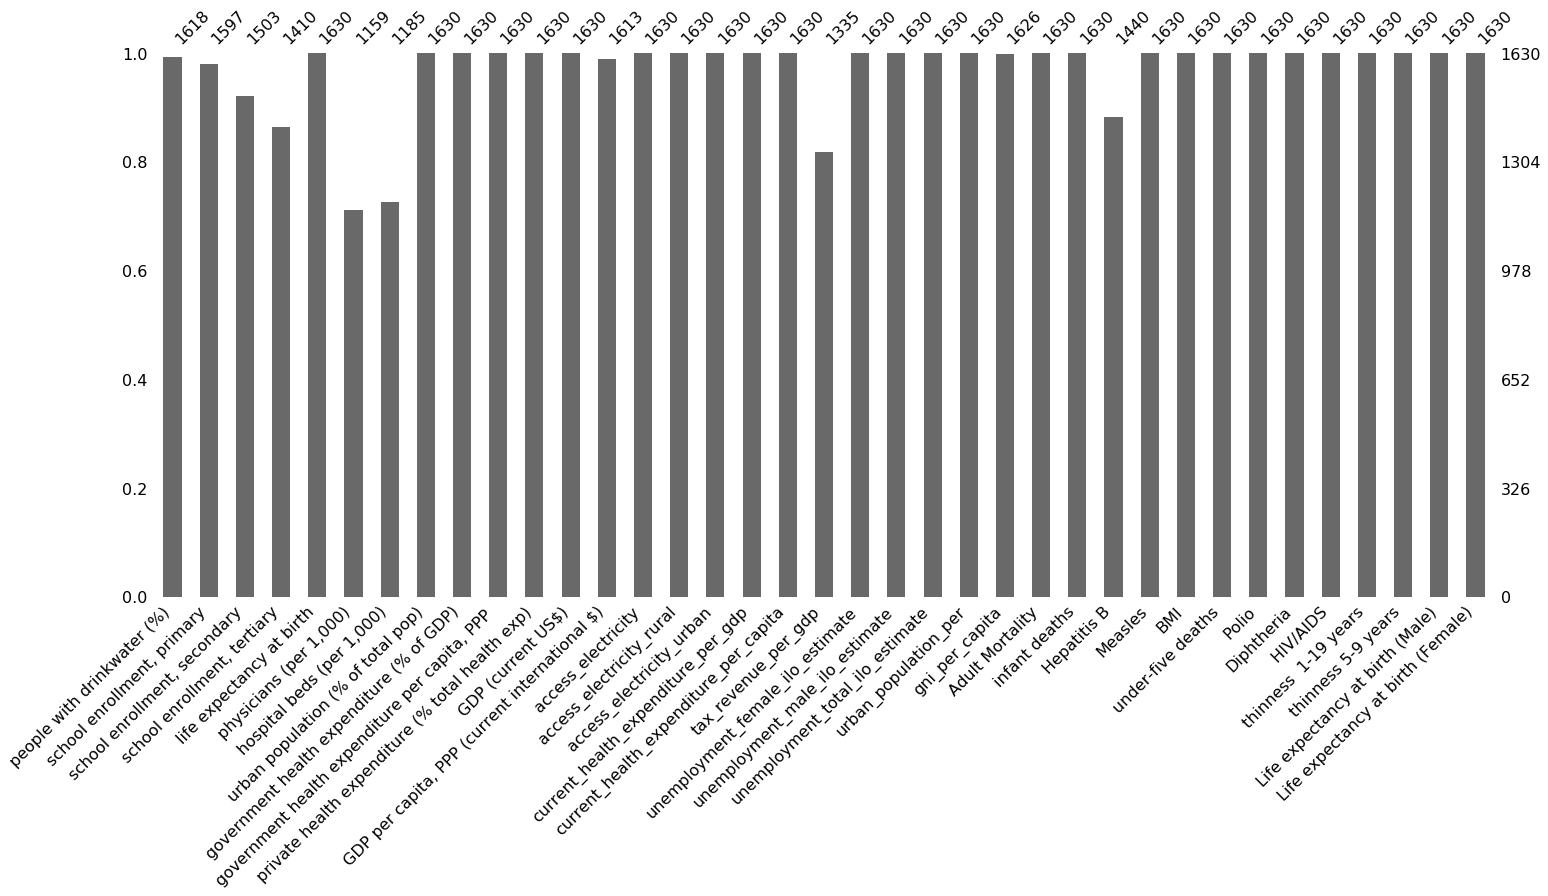

In [22]:
msno.bar(data_cleaned)

From the plot below, it can be seen that the missing values have patterns. It seems that there are countries with a very high percentage of missing values while others have less missing values.

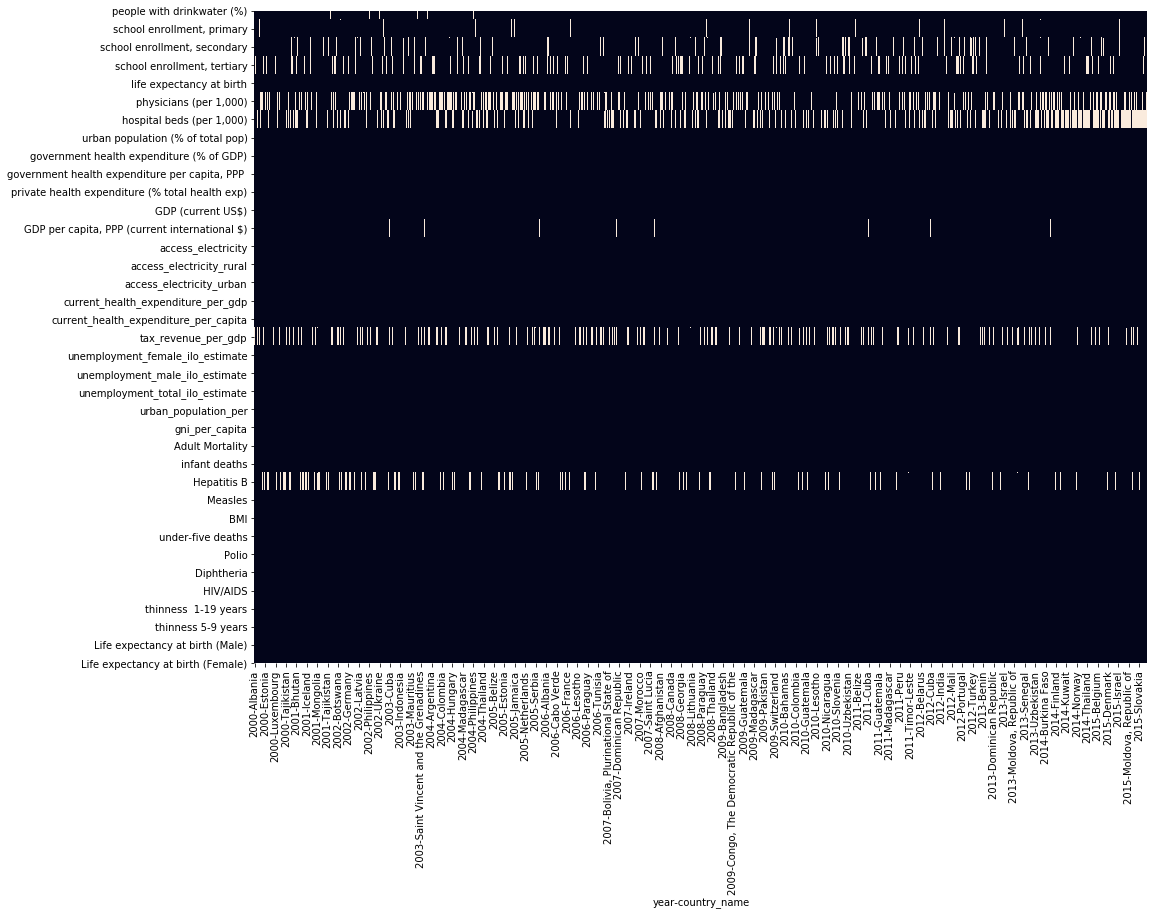

In [23]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(data_cleaned.T.isnull(), cbar=False);

### Outlier detection

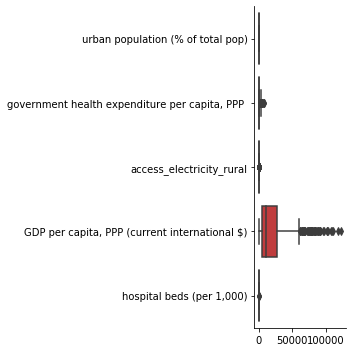

In [24]:
sns.catplot(data=data_cleaned.loc[:, data_cleaned.columns != \
                                  "life expectancy at birth"].sample(5, axis=1, random_state = 123), 
            orient="h", kind="box")

### Data Imputation 

In [25]:
imp_mice = IterativeImputer(random_state=42 )
    
data_imputed = data_cleaned
data_imputed[data_imputed.columns] = imp_mice.fit_transform(data_cleaned)

print('Do any more null values exist? Answer:' + str( data_imputed.isnull().values.any() ) )



# separate country into group by income according to worldbank method
#https://datahelpdesk.worldbank.org/knowledgebase/articles/906519-world-bank-country-and-lending-groups
incomegroups = pd.read_csv("income_groups.csv")

def group_country_by_income(x, limit_list):
    if x < limit_list[0]:
        return "low_income"
    elif x < limit_list[1]:
        return "lower_middle_income"
    elif x < limit_list[2]:
        return "upper_middle_income"
    elif x >= limit_list[3]:
        return "high_income"
    else:
        return np.NaN

for year in range(2000, 2017):
    selection_vector = data_imputed.index.get_level_values("year") == year
    data_imputed.loc[selection_vector, "income_group"] = data_cleaned.loc[selection_vector, "gni_per_capita"].apply(group_country_by_income, limit_list=incomegroups[str(year)].tolist())


Do any more null values exist? Answer:False


In [26]:
data_imputed.loc[:, ["life expectancy at birth", "gni_per_capita", "income_group"]]

life expectancy at birth  gni_per_capita  \
year country_name                                              
2000 Albania                       73.955000          1100.0   
     Armenia                       71.409000           660.0   
     Austria                       78.126829         26790.0   
     Belarus                       68.912195          1380.0   
     Belgium                       77.721951         25860.0   
...                                      ...             ...   
2015 Togo                          59.927000           640.0   
     Tunisia                       75.922000          3960.0   
     United States                 78.690244         56720.0   
     Uruguay                       77.369000         15640.0   
     Uzbekistan                    70.928000          2600.0   

                           income_group  
year country_name                        
2000 Albania        lower_middle_income  
     Armenia                 low_income  
     Austria                high_income  
     Belarus        lower_middle_income  
     Belgium                high_income  
...                                 ...  
2015 Togo                    low_income  
     Tunisia        lower_middle_income  
     United States          high_income  
     Uruguay                high_income  
     Uzbekistan     lower_middle_income  

[1630 rows x 3 columns]

In [27]:
#PREPROCESSING DONE 
data_final = data_imputed

### Data Exploration (Maroua)

#### What is the average human life expectancy in the world over time for male and female?

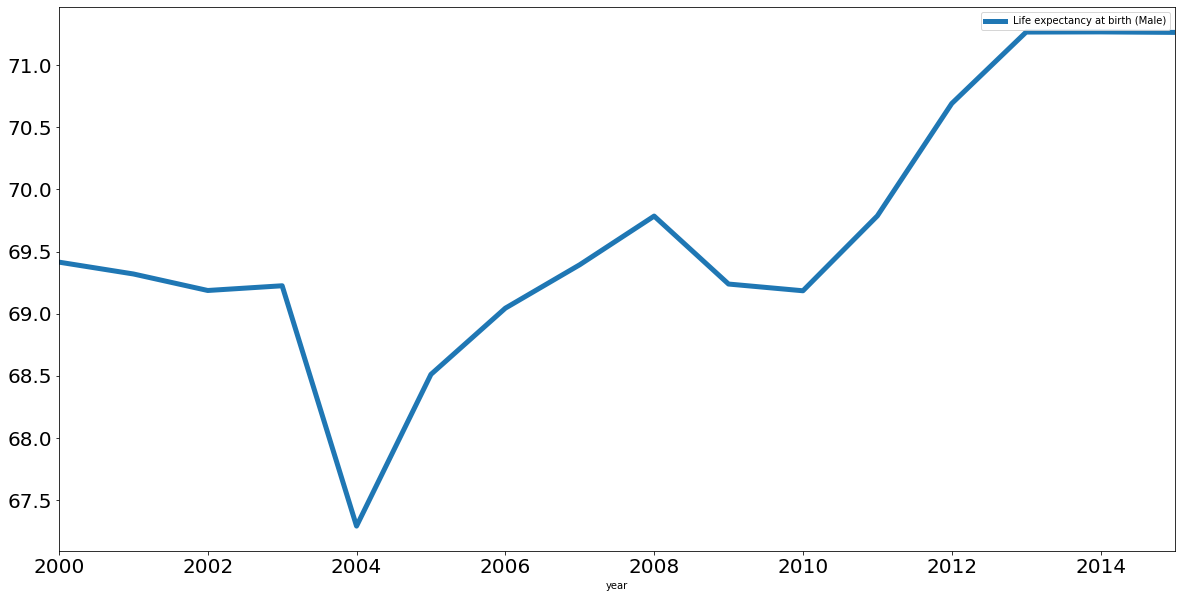

In [28]:
data_grouped = data_final.groupby("year").mean()
data_grouped[['Life expectancy at birth (Male)']].plot(figsize=(20,10), linewidth=5, fontsize=20)

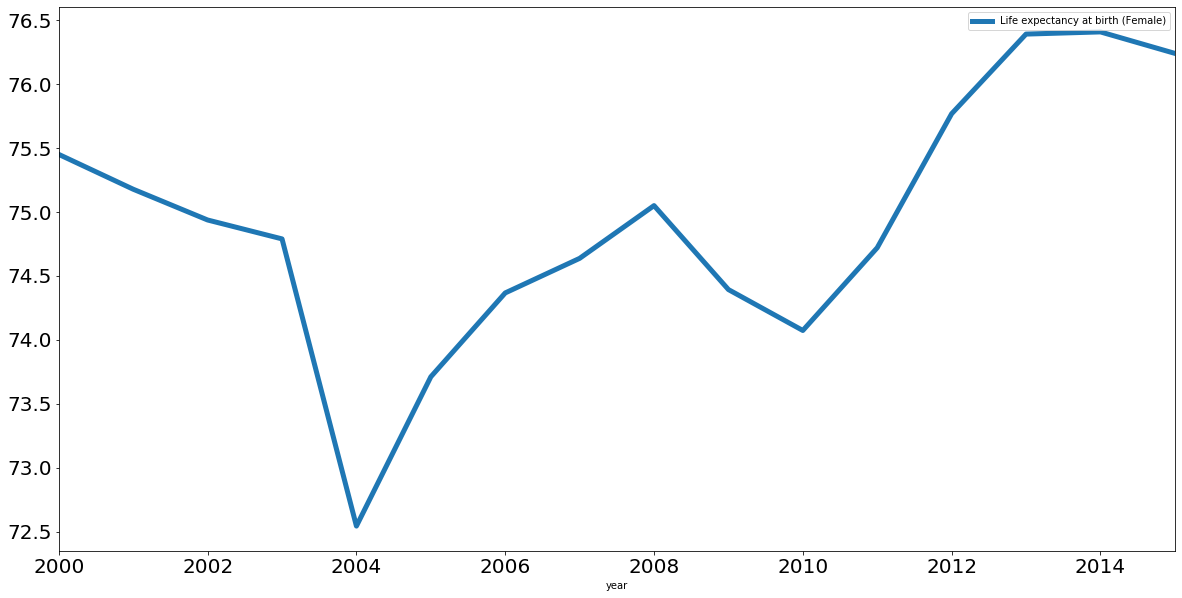

In [29]:
data_grouped = data_final.groupby("year").mean()
data_grouped[['Life expectancy at birth (Female)']].plot(figsize=(20,10), linewidth=5, fontsize=20)

### Data Exploration (Stephan)

In [30]:
country_list = set(data_final.index.get_level_values("country_name").tolist())
# make sure every country has a life expectancy of the last 17 years
#data_final["life expectancy at birth"].count()/len(country_list)
len(country_list)

157

In [31]:
life_exp = data_final.reset_index(level="country_name",drop=True).reset_index().loc[:, ["year", "life expectancy at birth"]]
life_exp

,year,life expectancy at birth
0,2000,73.955000
1,2000,71.409000
2,2000,78.126829
3,2000,68.912195
4,2000,77.721951
...,...,...
1625,2015,59.927000
1626,2015,75.922000
1627,2015,78.690244
1628,2015,77.369000


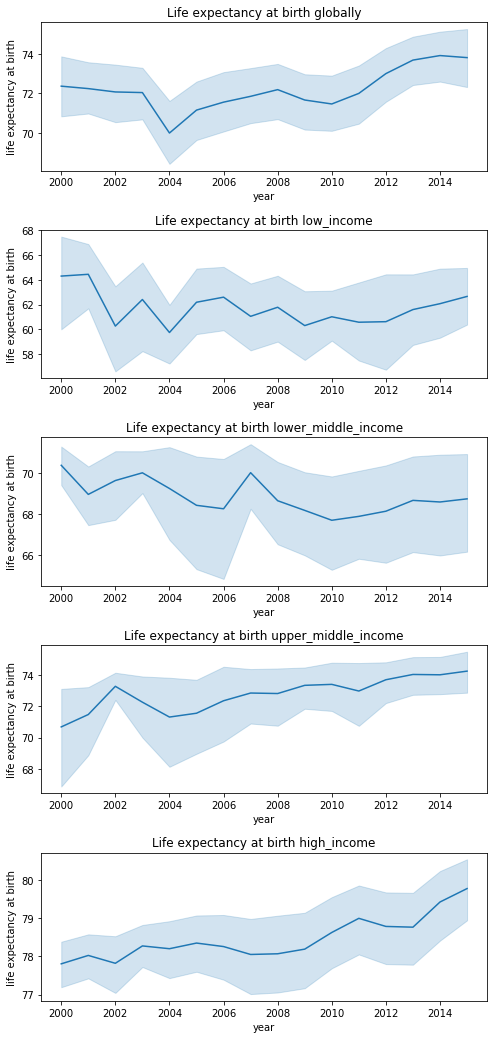

In [32]:
fig, ax = plt.subplots(5, 1, figsize=(8, 18))
plt.subplots_adjust(hspace = 0.4, wspace=1.0)

sns.lineplot(x="year", y="life expectancy at birth", data=life_exp, ci=95, ax=ax[0])
ax[0].set(title="Life expectancy at birth globally")

for index, group in enumerate(incomegroups["income_group"].tolist()):
    life_exp_group = data_final.reset_index(level="country_name",drop=True).reset_index()
    life_exp_group = life_exp_group.loc[life_exp_group["income_group"] == group, ["year", "life expectancy at birth"]]
    sns.lineplot(x="year", y="life expectancy at birth", data=life_exp_group, ci=95, ax=ax[index+1])
    ax[index+1].set(title="Life expectancy at birth " + group)

### Data Exploration (Investigating correlation between +++++++ and life expectancy) (Johannes)

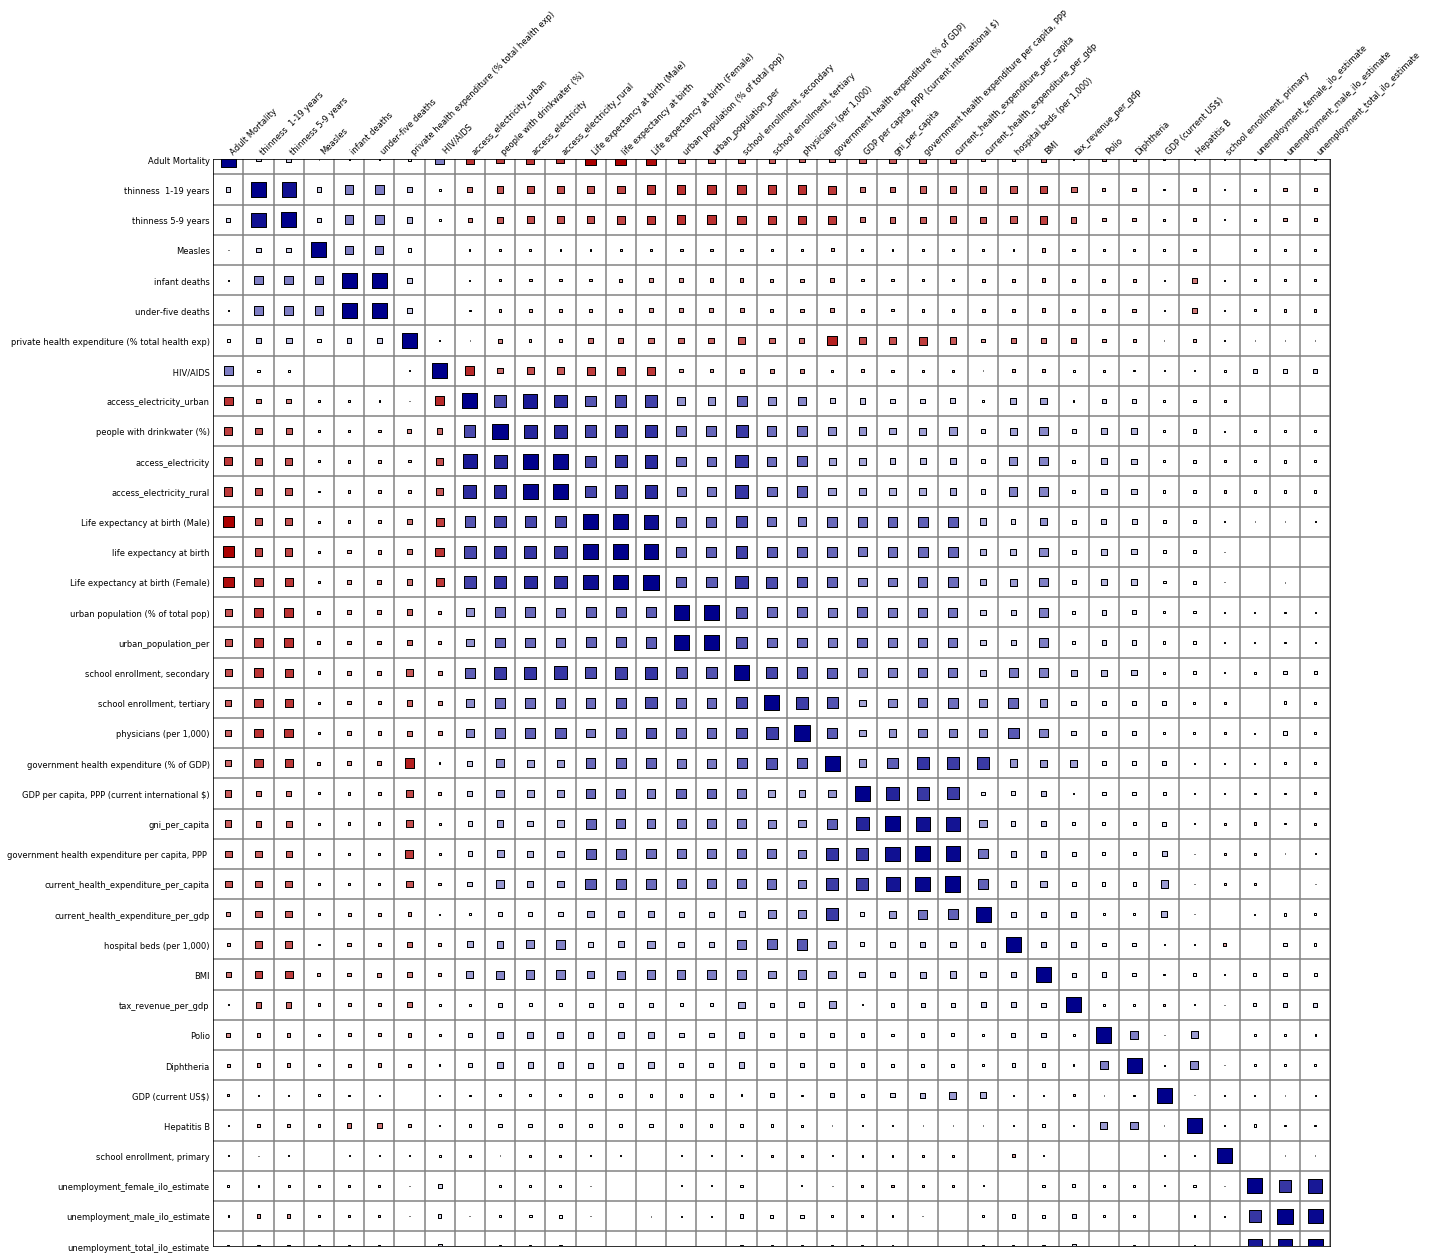

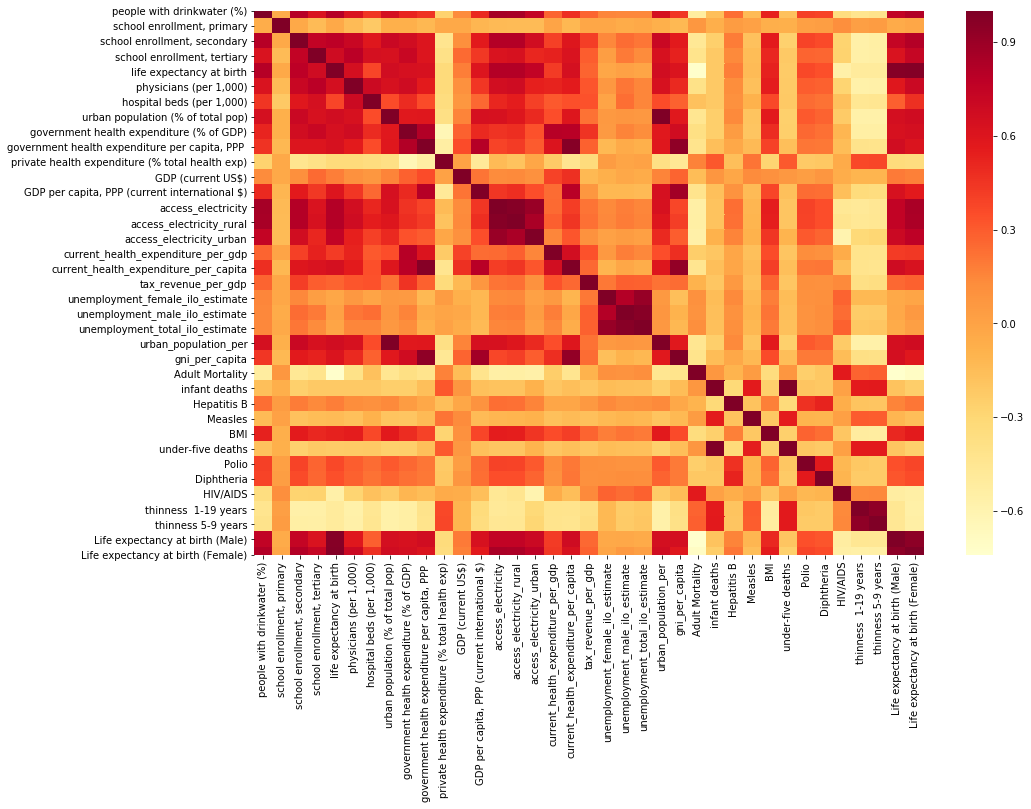

In [33]:
#Correlation Plot
correlations = data_final.corr()


f = plt.figure(figsize=(20, 25))
c = corrplot.Corrplot(correlations)
c.plot(fig=f, colorbar=False, method='square', shrink=.5 ,rotation=45)


f = plt.figure(figsize=(15,10))
sns.heatmap(correlations, cmap='YlOrRd')
plt.yticks(rotation= 0)
plt.xticks(rotation=90)
plt.show()

## Data Preprocessing

### Handling missing values

### Handling outliers

## Prediction

In [34]:
train = data_final[data_final.columns.difference(['life expectancy at birth', 'income_group'])]

target = data_final['life expectancy at birth']
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.20, random_state=42)

print('Training Set contains:' + str(len(X_train)) + ' elements')
print('Test Set contains:' + str(len(X_test)) + ' elements')

lasso_model = LassoCV(cv=5, random_state=42).fit(X_train, y_train)
print('R2 Score Lasso:'  + str(lasso_model.score(X_test, y_test)) ) 

#predictions = lasso_model.predict(X_test)
#lasso_mse = mean_squared_error(y_test, predictions)
#print('MSE Lasso: ' + str(lasso_mse))

#for i, coefficient in enumerate(lasso_model.coef_):
#    print('Coefficient for ' + train.columns[i] + ' is '+ str(coefficient))

Training Set contains:1304 elements
Test Set contains:326 elements
R2 Score Lasso:0.029523454697249155


In [35]:
print("Training Random Forest")
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 600, num = 2)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
min_samples_split = [3, 5, 9]
min_samples_leaf = [1, 2, 4]
bootstrap = [True]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}    
rf = RandomForestRegressor(random_state = 42)

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 10, verbose=2, random_state=42,
                               n_jobs=-1, scoring='neg_mean_squared_error')
rf_random.fit(X_train, y_train)

Training Random Forest
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 14.4min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [38]:
print('Best RF Score' + str(rf_random.best_score_))
neg_lasso_mse = np.mean(lasso_model.mse_path_) * -1
print('Lasso Score:' + str(neg_lasso_mse))

Best RF Score-0.3976420090956482
Lasso Score:-53.15126513739236
